# Walmart : Prediction de ventes
L'objectif est de construire est un modèle de machine learning capable d'estimer les chiffres de ventes hebdomadaire de leurs magasin.
Le modèle leur permettra de comprendre comment le chiffre d'affaires est influencé par certains indicateurs et de les utilisé par la suite dans leur campagne marketing.

In [97]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

In [98]:
df = pd.read_csv("data/Walmart_Store_sales.csv")

## Analyse exploratoire des données (EDA)

In [99]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [100]:
display(f"Nb rows : {df.shape[0]}, Nb columns : {df.shape[1]}")

print("Describe : ")
display(df.describe(include="all", datetime_is_numeric=True))

print("Missing value %")
display(df.isna().sum() * 100 / len(df))

'Nb rows : 150, Nb columns : 8'

Describe : 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


Missing value %


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

La date est en `string` donc on la converti en `datetime`

In [101]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

In [112]:
px.histogram(
    df,
    "Store",
    nbins=21
)

In [113]:
px.histogram(
    df.loc[df["Year"].isna() == False, :],
    x="Month",
    color = "Store",
    nbins= 12,
    facet_row="Year"
)

On regarde les correlation entre les differente colonne pour savoir si il y a des colonnes redondante (dont la corrélation == 1)

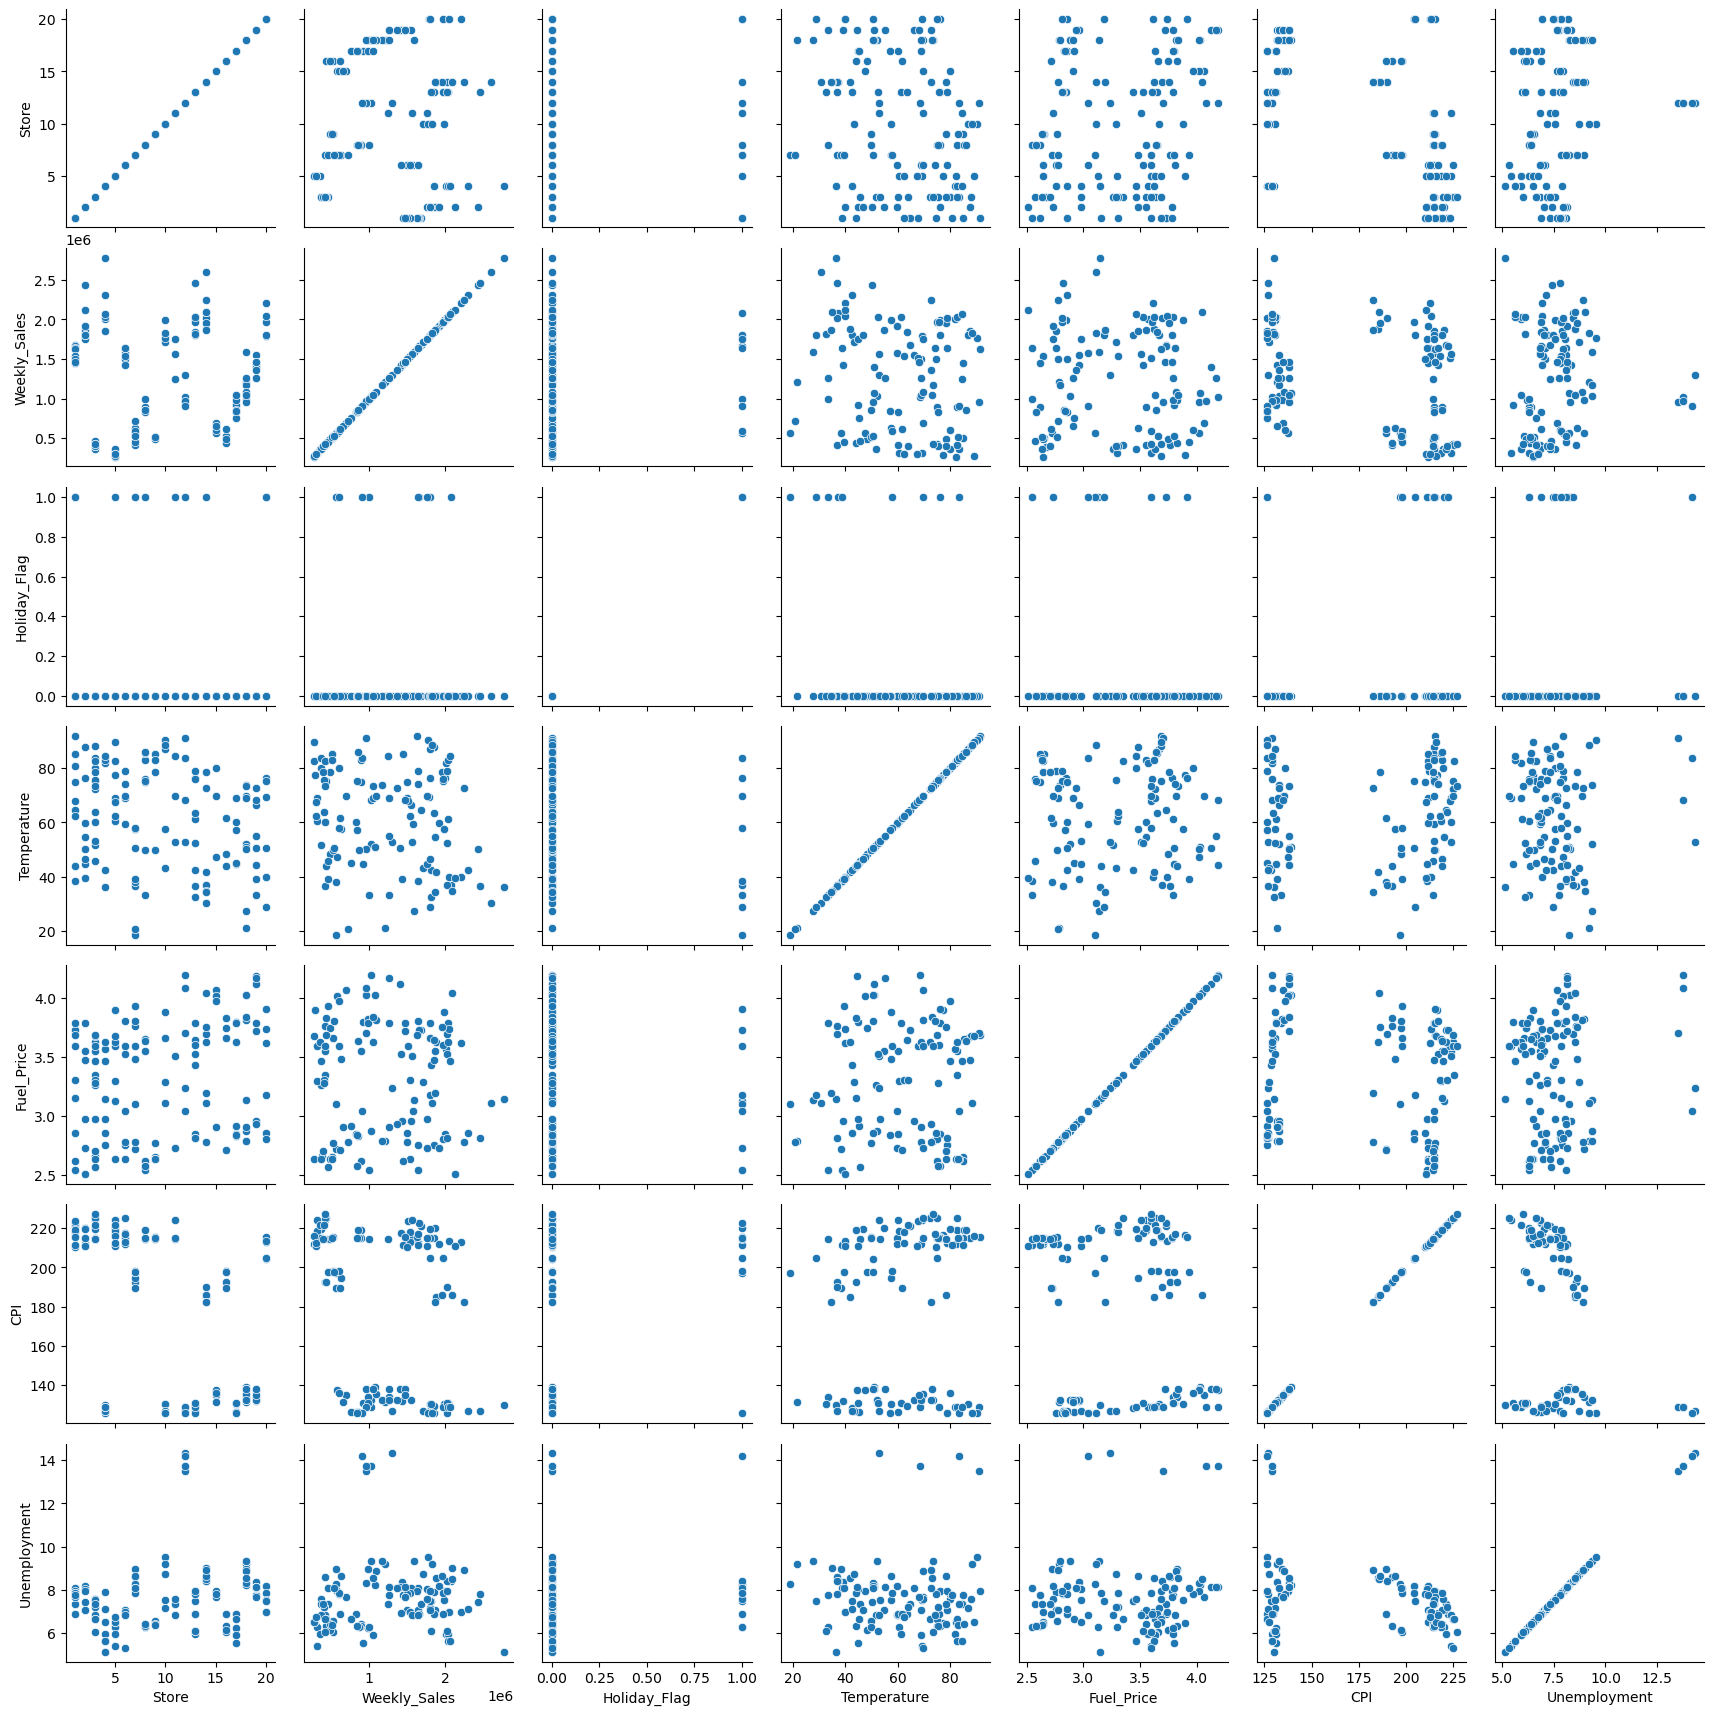

In [102]:
g = sns.PairGrid(df)
g.map(sns.scatterplot)

<Axes: >

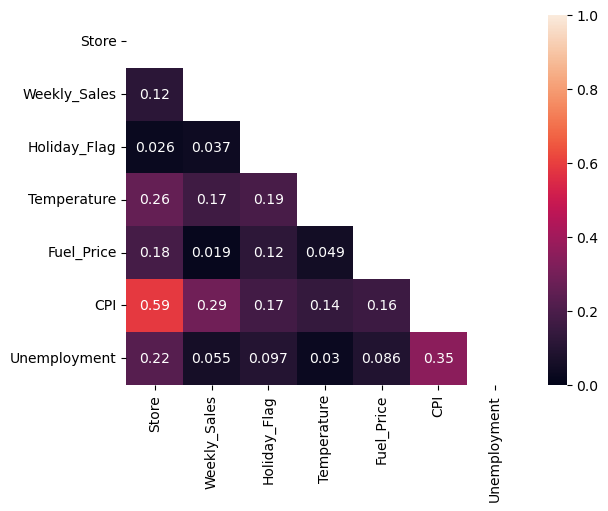

In [103]:
corr = df.corr(numeric_only=True).abs()

heatmap_mask = np.triu(corr)

sns.heatmap(corr, annot=True, vmin=0, vmax=+1, mask=heatmap_mask)


Il n'y a pas de correlation parfaite donc il n'y a pas de colonne en doublon.

## Preprocessing

### Colonnes
On ne supprime aucune colonne car aucune ne sont des uid, ni ont un pourcentage de valeurs de manquantes > 60%.
Pour la date, on créée plusieurs colonnes pour l'exploiter (année, mois, jour, jour de la semaine).

### Lignes
On supprimes les lignes avec des outliers, ici on garde une fênetre à 3 écart-type et les lignes où la target est manquante

### Imputation, normalisation, encoding
On gère l'imputation, la normalisation et l'encoding via la librairi scikit-learn.

Variables categorielles : Store, Holiday_flag

Variables numérique : Temperature, Fuel_price, CPI, Unemployment, Year, Month, Day, DayOfWeek

In [104]:
df["Year"] = df["Date"].dt.strftime('%Y')
df["Month"] = df["Date"].dt.strftime('%m')
df["Week"] = df["Date"].dt.strftime('%W')
df = df.drop("Date", axis=1)


# delete missing target
df = df.loc[df["Weekly_Sales"].isna() == False, :]

# delete outliers
outliers_column = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
for col in outliers_column:
    df = df.loc[(df[col].isna()) | ((df[col] > df[col].mean() - 3*df[col].std()) & (df[col] < df[col].mean() + 3*df[col].std())), :]

display(df.describe(include="all", datetime_is_numeric=True))
print("Missing value %")
display(df.isna().sum() * 100 / len(df))

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
count,136.000000,1.360000e+02,125.000000,121.000000,124.000000,125.000000,122.000000,118,118,118
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12,45
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,05,21
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,14,6
mean,10.014706,1.249536e+06,0.072000,60.853967,3.316992,178.091144,7.665582,NaN,NaN,NaN
std,6.124614,6.474630e+05,0.259528,18.514432,0.479540,40.243105,1.619428,NaN,NaN,NaN
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000,NaN,NaN,NaN
25%,4.000000,6.050757e+05,0.000000,45.220000,2.838500,131.637000,6.690000,NaN,NaN,NaN
50%,10.000000,1.261424e+06,0.000000,62.250000,3.451000,196.919506,7.477000,NaN,NaN,NaN
75%,15.250000,1.806386e+06,0.000000,75.950000,3.724000,214.878556,8.150000,NaN,NaN,NaN


Missing value %


Store            0.000000
Weekly_Sales     0.000000
Holiday_Flag     8.088235
Temperature     11.029412
Fuel_Price       8.823529
CPI              8.088235
Unemployment    10.294118
Year            13.235294
Month           13.235294
Week            13.235294
dtype: float64

Après la suppression des lignes des outliers et de la target manquante, il nous reste 131 lignes que l'on va pouvoir imputer, normaliser et encoder.

In [105]:
target_name = "Weekly_Sales"

Y = df.loc[:,target_name]
X = df.drop(target_name, axis = 1)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=1)

numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Week"]
categorical_features = ["Store", "Holiday_Flag"]

numeric_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encoder', OneHotEncoder(drop='first'))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Baseline Model

On effectue un test de model simple en prenant toutes les feature, et on regarde ce score de base que l'on essaiera par la suite de d'améliorer.

In [106]:
base_model = LinearRegression()
base_model.fit(X_train, Y_train) 

print(f"R2 score on training set :  {base_model.score(X_train, Y_train)}")
print(f"R2 score on test set :  {base_model.score(X_test, Y_test)}")

R2 score on training set :  0.9726270462037844
R2 score on test set :  0.9532657839259413


La différence est-elle significative ? 

On fait une cross validation pour savoir si cette différence est supérieur à l'écart-type.

In [107]:
X_cv = preprocessor.fit_transform(X)
Y_cv = Y

scores = cross_val_score(base_model, X_cv, Y_cv, cv=5)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

The cross-validated R2-score is :  0.9467825886000873
The standard deviation is :  0.02091785347477027


On remarque que le baseline model est légèrement overfitté car l'écart entre le test et le train est de ~ 0.08 alors que l'écart type du dataset est de ~ 0.02.

On va donc travailler le modèle pour réduire cette overfitting.

D'abord, on regarde les coefficients de chaque feature pour savoir lesquelles sont les plus importantes dans ce modèle.

In [108]:
def display_features_importance(model, is_grid_search):
    column_names = []
    for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
        if name == 'num': # if pipeline is for numeric variables
            features = features_list # just get the names of columns to which it has been applied
        else: # if pipeline is for categorical variables
            features = pipeline.named_steps['encoder'].get_feature_names_out(categorical_features) # get output columns names from OneHotEncoder
        column_names.extend(features) # concatenate features names

    if (is_grid_search):
        coefs = pd.DataFrame(index = column_names, data = np.absolute(model.best_estimator_.coef_.transpose()), columns=["coefficients"])
    else:
        coefs = pd.DataFrame(index = column_names, data = np.absolute(model.coef_.transpose()), columns=["coefficients"])
    
    coefs = coefs.sort_values(by=["coefficients"], ascending=False)

    fig = px.bar(
        coefs, 
        orientation = 'h',
        text_auto='.2s',
        title="Importance des features",
        height=700
    )
    fig.update_layout(
        showlegend = False, 
        title= {
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title="Coefficient",
        yaxis_title="Features",
    )

    fig.show()

In [109]:
display_features_importance(base_model, False)

On remarque que les features les plus importantes pour le modèle sont les indentifiants des magasins au détriments des indicateurs économiques (CPI, Unemployement). Cela s'explique par le fait que les magasins font des chiffres de ventes différent. Mais c'est aussi peut-être la source de l'overfitting du modèle.

On va essayer de régularizer ce modèle pour voir si cela l'améliore.

In [110]:
ridge = Ridge()

params_ridge = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 100.0]
}
gs_ridge = GridSearchCV(ridge , param_grid = params_ridge, cv = 5)
gs_ridge.fit(X_train, Y_train)

print("Best hyperparameters : ", gs_ridge.best_params_)
print("Best R2 score : ", gs_ridge.best_score_)
print()
print("R2 score on training set : ", gs_ridge.score(X_train, Y_train))
print("R2 score on test set : ", gs_ridge.score(X_test, Y_test))

display_features_importance(gs_ridge, True)

Best hyperparameters :  {'alpha': 0.1}
Best R2 score :  0.9364594376019074

R2 score on training set :  0.9713357251089861
R2 score on test set :  0.9549918634646519


In [111]:
lasso = Lasso(max_iter = 5000)

params_lasso = {
    'alpha': [10.0, 50, 80, 100.0, 200, 300, 500, 600, 700, 800, 900, 1000]
}
gs_lasso = GridSearchCV(lasso , param_grid = params_lasso, cv = 5)
gs_lasso.fit(X_train, Y_train)

print("Best hyperparameters : ", gs_lasso.best_params_)
print("Best R2 score : ", gs_lasso.best_score_)
print()
print("R2 score on training set : ", gs_lasso.score(X_train, Y_train))
print("R2 score on test set : ", gs_lasso.score(X_test, Y_test))

display_features_importance(gs_lasso, True)

Best hyperparameters :  {'alpha': 500}
Best R2 score :  0.9368120854915132

R2 score on training set :  0.9712510663650733
R2 score on test set :  0.957071796501446


On remarque que meme avec une régularisation, le modèle ne s'améliore pas.

Cela peut s'expliquer par le jeu de données peu conséquent (150 lignes, réduites à 130 après le preprocessing) où certains magasins sont sur-représentés par rapport à d'autres. Il faut aussi noter qu'aucun magasin ne possède de données de chiffres de ventes pour chaque semaines, les données sont peu nombreuses et fragmentées dans le temps pour chaque magasin.

On peut aussi relativiser les scores car meme si il y a un léger overfitting, le modèle obtient un score de 97% - 90%. Le score du tests s'améliorera peut-être si le nombre de données augmente.